In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
from PIL import Image
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

sns.set(style="whitegrid")
BASE_PATH = "/kaggle/input/faces-artefact-recognition/trainee_dataset"
IMG_SIZE = (244, 244)


In [15]:
def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []
    for label in ['0', '1']:
        folder = os.path.join(base_dir, label)
        for img_path in glob(os.path.join(folder, "*.png")):
            image_paths.append(img_path)
            labels.append(int(label))
    return image_paths, labels

train_paths, train_labels = get_image_paths_and_labels(os.path.join(BASE_PATH, "train"))
test_paths, test_labels = get_image_paths_and_labels(os.path.join(BASE_PATH, "test"))

print(f"Train size: {len(train_paths)}, Test size: {len(test_paths)}")

Train size: 1800, Test size: 200


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


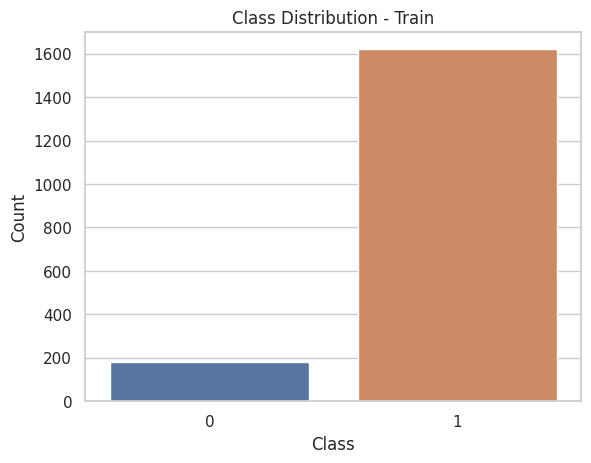

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


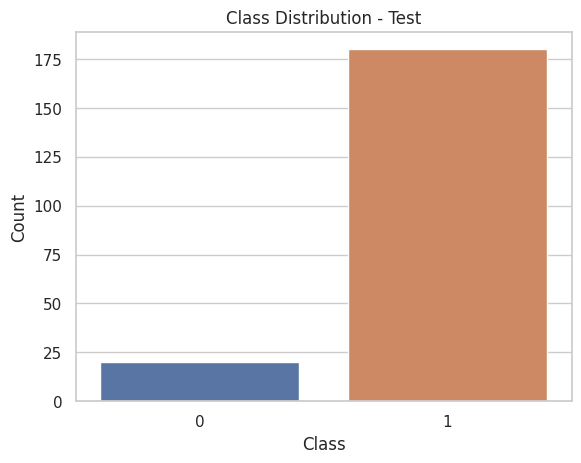

In [16]:
def plot_class_distribution(labels, split_name):
    counter = Counter(labels)
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(f"Class Distribution - {split_name}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(train_labels, "Train")
plot_class_distribution(test_labels, "Test")

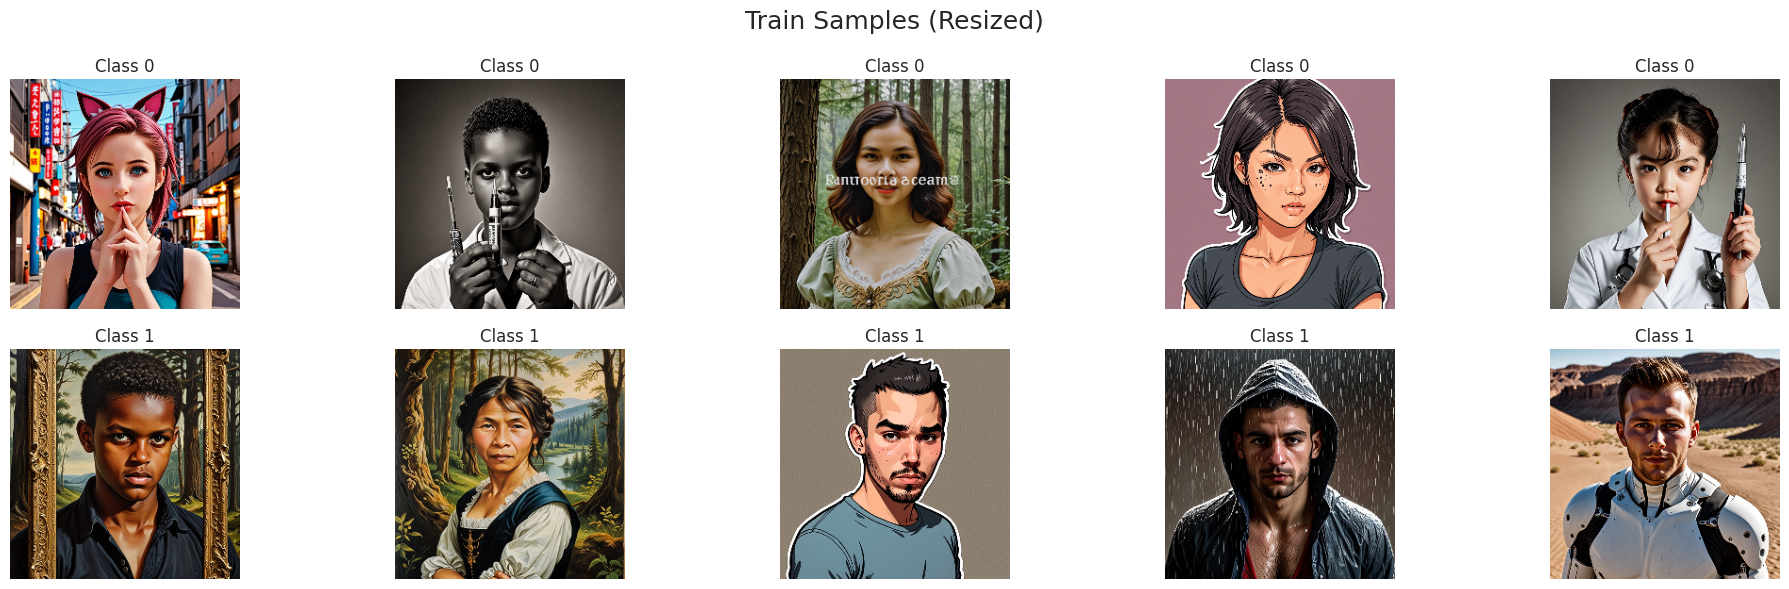

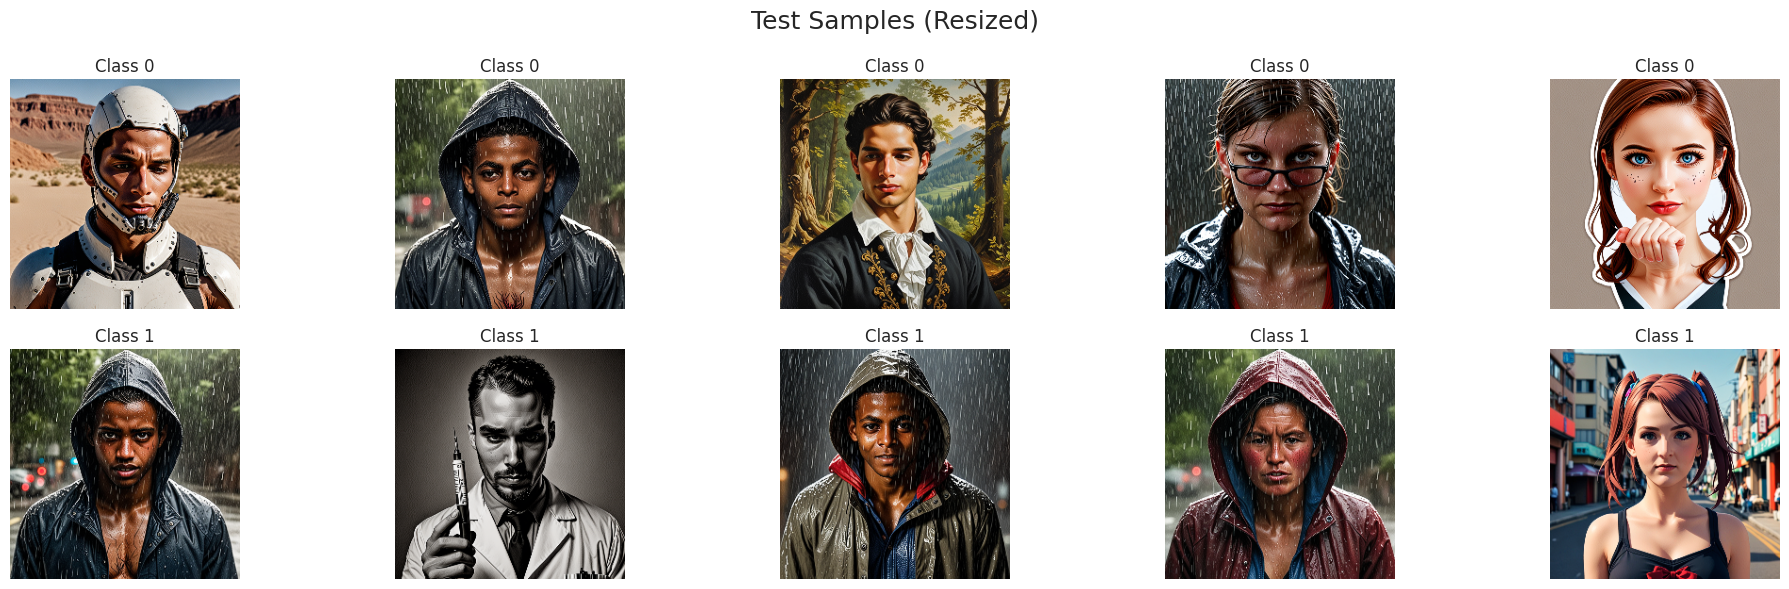

In [17]:
def show_image_samples(image_paths, labels, title, n=5):
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 6))
    fig.suptitle(title, fontsize=18)

    for i, class_label in enumerate([0, 1]):
        class_images = [p for p, l in zip(image_paths, labels) if l == class_label][:n]
        for j, path in enumerate(class_images):
            img = cv2.imread(path)
            img = cv2.resize(img, IMG_SIZE)
            axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Class {class_label}")
    plt.tight_layout()
    plt.show()

show_image_samples(train_paths, train_labels, "Train Samples (Resized)")
show_image_samples(test_paths, test_labels, "Test Samples (Resized)")

Image Size Statistics:
        width  height
count  1800.0  1800.0
mean   1024.0  1024.0
std       0.0     0.0
min    1024.0  1024.0
25%    1024.0  1024.0
50%    1024.0  1024.0
75%    1024.0  1024.0
max    1024.0  1024.0

Brightness Statistics:
count    1800.000000
mean       97.210595
std        22.759154
min        49.340467
25%        80.507422
50%        95.097046
75%       115.952447
max       146.878084
dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


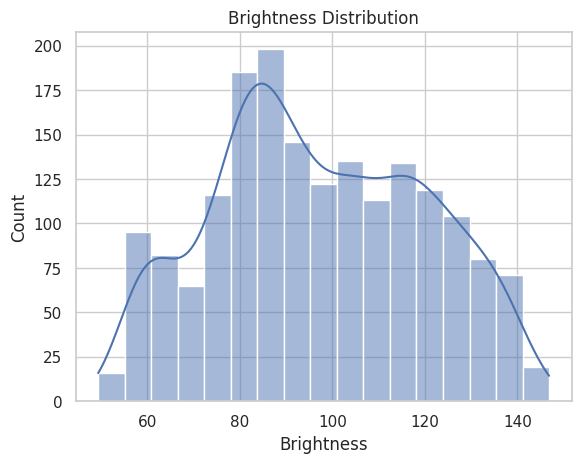

In [18]:
def analyze_image_stats(image_paths):
    sizes = []
    brightness = []

    for path in image_paths:
        img = Image.open(path).convert("L")
        sizes.append(img.size)
        brightness.append(np.array(img).mean())

    size_df = pd.DataFrame(sizes, columns=["width", "height"])
    print("Image Size Statistics:")
    print(size_df.describe())

    print("\nBrightness Statistics:")
    print(pd.Series(brightness).describe())

    sns.histplot(brightness, kde=True)
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness")
    plt.show()

analyze_image_stats(train_paths)

In [19]:
def check_and_remove_duplicates(image_paths):
    hashes = {}
    duplicates = []

    for path in image_paths:
        img = Image.open(path).resize(IMG_SIZE)
        img_hash = hash(img.tobytes())

        if img_hash in hashes:
            print(f"Duplicate found: {path}, removing...")
            duplicates.append(path)
        else:
            hashes[img_hash] = path

    for dup_path in duplicates:
        try:
            os.remove(dup_path)
        except Exception as e:
            print(f"Failed to delete {dup_path}: {e}")

    print(f"Removed {len(duplicates)} duplicates.")

    return [p for p in image_paths if p not in duplicates]  # оновлений список


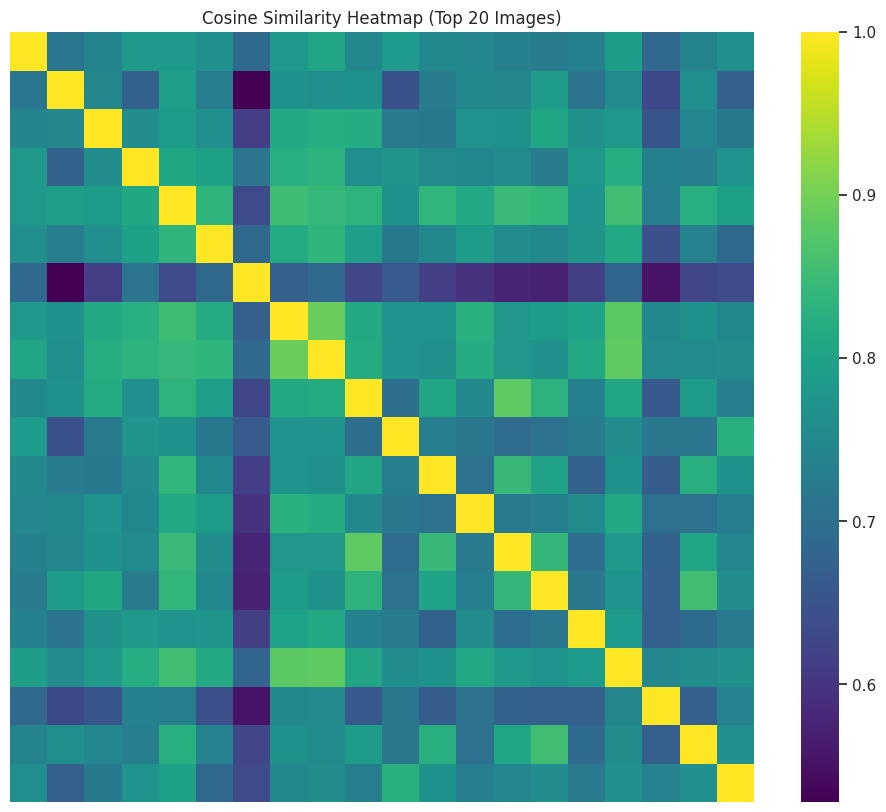

In [20]:
def plot_image_similarity_heatmap(image_paths, n=20):
    selected_paths = image_paths[:n]
    images = []

    for path in selected_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE).flatten()
        images.append(img)

    sim_matrix = cosine_similarity(images)

    plt.figure(figsize=(12, 10))
    sns.heatmap(sim_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title(f"Cosine Similarity Heatmap (Top {n} Images)")
    plt.show()

plot_image_similarity_heatmap(train_paths, n=20)